## Retrieve data from DB
PTEN:
- DMS scores: https://www.mavedb.org/score-sets/urn:mavedb:00000013-a-1
- Pairwise Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog/Alignment?db=core;g=ENSG00000171862;g1=ENSDARG00000056623;hom_id=202046236;r=10:87862638-87971930

PAX6 Homeobox domain:
- https://www.mavedb.org/score-sets/urn:mavedb:00000949-a-1
- Multiple Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog?db=core;g=ENSG00000007372;r=11:31784779-31817961

In [1]:
import sqlite3
from prettytable import PrettyTable
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Connect to the database
conn = sqlite3.connect('compar_gen_data.db')
cursor = conn.cursor()

In [204]:
# all functions

# Print table content
def print_table(table_name):
    table = PrettyTable()
    query = ""
    field_names = []

    if table_name == "Species":
        query = "SELECT * FROM Species"
        field_names = ["Species ID", "Species Name"]
        
    elif table_name == "Gene":
        query = "SELECT * FROM Gene"
        field_names = ["Gene ID", "Gene Name"]

    elif table_name == "Mutation":
        query = '''
            SELECT Mutation.mutation_id, Gene.gene_name, Species.species_name, Mutation.position, 
                   Mutation.ancestral_residue, Mutation.variant_residue
            FROM Mutation
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            JOIN Species ON Mutation.species_id = Species.species_id
        '''
        field_names = ["Mutation ID", "Gene", "Species", "Position", "Ancestral", "Variant"]

    elif table_name == "DMS":
        query = '''
            SELECT DMS.dms_id, Gene.gene_name, Mutation.position, Mutation.ancestral_residue, 
                   Mutation.variant_residue, DMS.score
            FROM DMS
            JOIN Mutation ON DMS.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = 'PAX6'
            ORDER BY Mutation.position
        '''
        field_names = ["DMS ID", "Gene", "Position", "Ancestral", "Variant", "Score"]

    elif table_name == "MSA":
        query = '''
            SELECT MSA.msa_id, Gene.gene_name, Species.species_name, Mutation.position, Mutation.ancestral_residue, 
                   Mutation.variant_residue, ROUND(MSA.shannon_entropy, 3), ROUND(MSA.percentage_identity, 3)
            FROM MSA
            JOIN Mutation ON MSA.mutation_id = Mutation.mutation_id
            JOIN Species ON Mutation.species_id = Species.species_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = 'PAX6'
                AND (Species.species_name='ENSTNIP00000016806_Tnig')
            ORDER BY Mutation.position
        '''
        field_names = ["MSA ID", "Gene", "Species", "Position", "Ancestral", "Variant", "shannon", "% identity"]

    elif table_name == "IntegratedData":
        query = '''
            SELECT IntegratedData.integrated_data_id, Gene.gene_name, Mutation.position,
                   Mutation.ancestral_residue, Mutation.variant_residue, ROUND(IntegratedData.shannon_entropy, 3),
                   ROUND(IntegratedData.percentage_identity, 3), ROUND(IntegratedData.dms_score, 3)
            FROM IntegratedData
            JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = 'PAX6'
            GROUP BY Mutation.position, Mutation.ancestral_residue, Mutation.variant_residue
            ORDER BY Mutation.position
        '''
        field_names = ["IntegratedData_ID", "Gene", "Position", "Ancestral", "Variant", 
                       "Shannon", "% Identity", "DMS_score"]
        
    else:
        print(f"Table '{table_name}' is not recognized.")
        return

    cursor.execute(query)
    data = cursor.fetchall()

    table.field_names = field_names
    for row in data:
        table.add_row(row)
    
    print(f"{table_name}:")
    print(table)
    print('')

# Clean table content
def clean_table(table):
    cursor.execute(f'''
        DELETE FROM {table}
    ''')
    conn.commit()
    print(f"{table} table cleaned successfully.")

def remove_records(table, field_name, field_value):
    sql_query = f"DELETE FROM {table} WHERE {field_name} = ?"
    cursor.execute(sql_query, (field_value,))
    conn.commit()

#does not work, need to fix:
def remove_records_by_foreign_key(table, foreign_key_field, referenced_table, referenced_field, referenced_value):
    sql_query = f"SELECT {referenced_field} FROM {referenced_table} WHERE {referenced_field} = ?"
    cursor.execute(sql_query, (referenced_value,))
    referenced_ids = cursor.fetchall()
    referenced_ids = tuple(id_[0] for id_ in referenced_ids)
    sql_query = f"DELETE FROM {table} WHERE {foreign_key_field} IN ({','.join('?' * len(referenced_ids))})"
    cursor.execute(sql_query, referenced_ids)
    conn.commit()

In [205]:
# PRINT table
#print_table("Species")
#print_table("Gene")
#print_table("Mutation")
print_table("IntegratedData")
print_table("MSA")
print_table("DMS")

IntegratedData:
+-------------------+------+----------+-----------+---------+---------+------------+-----------+
| IntegratedData_ID | Gene | Position | Ancestral | Variant | Shannon | % Identity | DMS_score |
+-------------------+------+----------+-----------+---------+---------+------------+-----------+
|         24        | PAX6 |    12    |     A     |    N    |  0.239  |   0.969    |   -0.31   |
|         25        | PAX6 |    12    |     A     |    S    |  0.239  |   0.969    |   -0.11   |
+-------------------+------+----------+-----------+---------+---------+------------+-----------+

MSA:
+--------+------+-------------------------+----------+-----------+---------+---------+------------+
| MSA ID | Gene |         Species         | Position | Ancestral | Variant | shannon | % identity |
+--------+------+-------------------------+----------+-----------+---------+---------+------------+
| 446117 | PAX6 | ENSTNIP00000016806_Tnig |    1     |     N     |    N    |  0.167  |   0.978  

In [160]:
# CLEAN table
table_name = 'DMS'
clean_table(table_name)

DMS table cleaned successfully.


In [133]:
cursor.execute(f'''
        DELETE FROM MSA
        WHERE mutation_id IN (
            SELECT Mutation.mutation_id
            FROM Mutation
            JOIN Species ON Mutation.species_id = Species.species_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = 'PAX6'
        );
    ''')
conn.commit()

## Visualizations

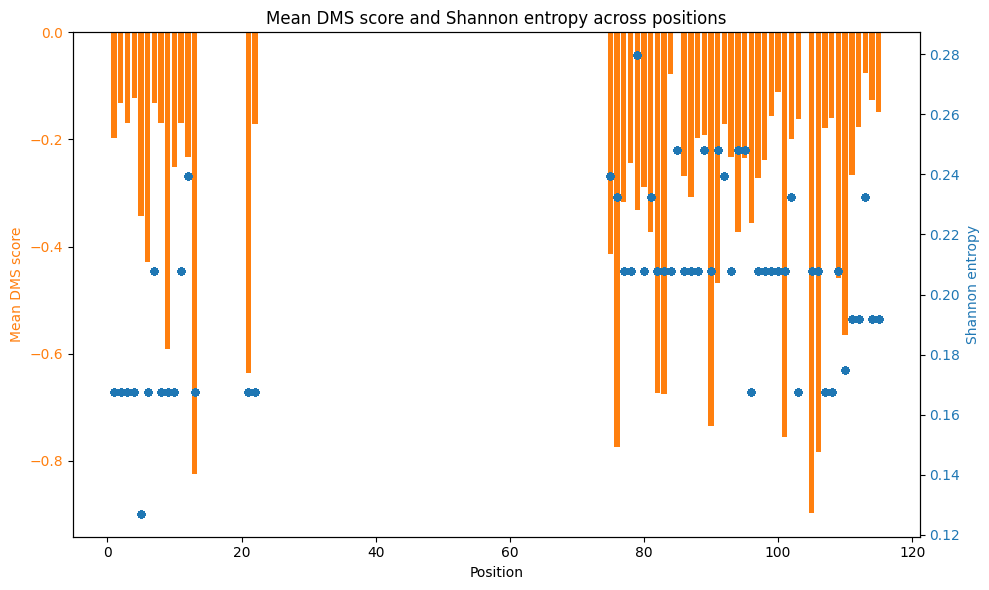

In [18]:
# Fetch data from MSA table
msa_query = '''
    SELECT Mutation.position, MSA.shannon_entropy
    FROM MSA
    JOIN Mutation ON MSA.mutation_id = Mutation.mutation_id
    WHERE Mutation.gene_id = (SELECT gene_id FROM Gene WHERE gene_name = 'PAX6')
'''
msa_df = pd.read_sql_query(msa_query, conn)

# Fetch data from DMS table
dms_query = '''
    SELECT Mutation.position, DMS.score
    FROM DMS
    JOIN Mutation ON DMS.mutation_id = Mutation.mutation_id
    WHERE Mutation.gene_id = (SELECT gene_id FROM Gene WHERE gene_name = 'PAX6')
'''
dms_df = pd.read_sql_query(dms_query, conn)

# Calculate mean DMS score for each position
mean_dms_scores = dms_df.groupby('position')['score'].mean().reset_index()

# Merge MSA and mean DMS score data on position
merged_df = pd.merge(msa_df, mean_dms_scores, on='position', how='inner')

# Sort the dataframe by position
merged_df.sort_values('position', inplace=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for mean DMS scores
color = 'tab:orange'
ax1.set_xlabel('Position')
ax1.set_ylabel('Mean DMS score', color=color)
bars = ax1.bar(merged_df['position'], merged_df['score'], color=color, alpha=0.6, label='Mean DMS score')
ax1.tick_params(axis='y', labelcolor=color)

# Scatter plot for Shannon entropy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Shannon entropy', color=color)
scatter = ax2.scatter(merged_df['position'], merged_df['shannon_entropy'], color=color, label='Shannon entropy',
                      s=20, zorder=10)  # Adjust marker size (s) as needed
ax2.tick_params(axis='y', labelcolor=color)

# Title and labels
plt.title('Mean DMS score and Shannon entropy across positions')
fig.tight_layout()

# Show plot
plt.show()


In [ ]:
# Close the connection
conn.close()